In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.patches as patches
import re

# CENG0013: Process Design Principle's Pinch Method

In [2]:
def load_data(file_path):
    """Load data from an Excel file and adjust the DataFrame index."""
    data = pd.read_excel(file_path)
    data.index = data.index + 1  # Shift index to start from 1
    return data

In [3]:
def calculate_duty_and_flux(dataframe):
    """Calculate duty and flux for each stream and add as new columns to the DataFrame."""
    duties = []
    fluxes = []
    for i in range(1, len(dataframe) + 1):
        duty_kj_hr = dataframe['Cp (kJ/kmol/K)'][i] * dataframe['T_diff'][i] * dataframe['Molar Flow Rate [kmol/hr]'][i]
        duty_kw = duty_kj_hr / 3600  # Convert to kW
        flux_kw_k = duty_kw / dataframe['T_diff'][i]

        duties.append(duty_kw)
        fluxes.append(flux_kw_k)

    dataframe['Duty [kW]'] = duties
    dataframe['Flux [kW / K]'] = fluxes
    return dataframe

In [4]:
# Load the stream data
stream_data = load_data('streams/AEStreamTable3.xlsx')

# Calculate duty and flux and update the DataFrame
updated_stream_data = calculate_duty_and_flux(stream_data)

updated_stream_data

,Stream Number,Type,Molar Flow Rate [kmol/hr],Tin,Tout,T_diff,Cp_in (kJ/kmol/K),Cp_out (kJ/kmol/K),Cp (kJ/kmol/K),Duty [kW],Flux [kW / K]
1,S5/7,cold,313.345610,124.918722,498,-373.081278,202.418556,229.294689,215.856622,-7009.546912,18.788257
2,S10/11,hot,256.000000,719.063689,620,99.063689,30.180581,29.830959,30.005770,211.376517,2.133744
3,S13/14,hot,575.429318,500.753518,2,498.753518,137.601229,85.515289,111.558259,8893.591642,17.831637
4,S24/25,cold,6.083709,129.316828,620,-490.683172,50.321515,60.067363,55.194439,-45.768048,0.093274
5,S26/27,cold,157.351358,7.011657,150,-142.988343,131.111820,191.124903,161.118361,-1006.963352,7.042276
6,S28/29,hot,339.142154,150.000000,25,125.000000,134.301341,143.337100,138.819220,1634.703104,13.077625
7,S32/33,cold,9.073612,24.999994,150,-125.000006,29.051641,29.725236,29.388438,-9.259004,0.074072
8,S34/35,cold,162.598652,99.634877,150,-50.365123,168.062864,192.782166,180.422515,-410.426196,8.149016
9,S37/38,hot,500.000000,838.198348,150,688.198348,30.659933,29.249319,29.954626,2863.156110,4.160365
10,S52/53,hot,215.001600,191.510967,100,91.510967,229.563055,208.255375,218.909215,1196.399933,13.073842


# Set the minimum driving force $\Delta T_{min}$ and construct the temperature interval table

In [5]:
def constructTemperatureInterval(df, Tmin):
    """
    Constructs temperature intervals from stream data in a DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing stream data.
    Tmin (float): Minimum temperature difference.

    Returns:
    DataFrame: DataFrame containing temperature intervals.
    """
    temperatures = []
    for index, row in df.iterrows():
        temperatures.append((row['Tin'], row['Type'], 'supply', row['Stream Number']))
        temperatures.append((row['Tout'], row['Type'], 'target', row['Stream Number']))

    temperatures.sort(reverse=True, key=lambda x: x[0])

    interval_data = []
    for temp, stream_type, temp_type, stream_number in temperatures:
        t_high = temp + Tmin if stream_type.lower() == 'cold' else temp
        t_low = temp if stream_type.lower() == 'cold' else max(temp - Tmin, 0)
        interval_data.append({'t1': max(t_high, t_low), 't2': min(t_high, t_low), 
                              'streamNumbers_hot': [], 'streamNumbers_cold': []})

    intervals_df = pd.DataFrame(interval_data)
    intervals_df.sort_values(by='t1', ascending=False, inplace=True)

    # Assign streams to intervals
    for index, interval in intervals_df.iterrows():
        for idx, row in df.iterrows():
            if row['Type'].lower() == 'hot' and row['Tin'] >= interval['t1'] and row['Tout'] <= interval['t1']:
                interval['streamNumbers_hot'].append(row['Stream Number'])
            elif row['Type'].lower() == 'cold' and row['Tin'] <= interval['t2'] and row['Tout'] >= interval['t2']:
                interval['streamNumbers_cold'].append(row['Stream Number'])

    # Convert lists to strings to remove duplicates
    intervals_df['streamNumbers_hot'] = intervals_df['streamNumbers_hot'].apply(lambda x: ','.join(map(str, x)))
    intervals_df['streamNumbers_cold'] = intervals_df['streamNumbers_cold'].apply(lambda x: ','.join(map(str, x)))

    # Remove duplicate intervals
    intervals_df = intervals_df.drop_duplicates(subset=['t1', 't2', 'streamNumbers_cold', 'streamNumbers_hot'])

    # Convert strings back to lists if needed
    intervals_df['streamNumbers_hot'] = intervals_df['streamNumbers_hot'].apply(lambda x: x.split(',') if x else [])
    intervals_df['streamNumbers_cold'] = intervals_df['streamNumbers_cold'].apply(lambda x: x.split(',') if x else [])
    
    return intervals_df

# $\Delta T_{min}$ chosen as 10°C

In [6]:
Temp_intervals = constructTemperatureInterval(updated_stream_data, 10)
Temp_intervals.reset_index(drop=True)

,t1,t2,streamNumbers_hot,streamNumbers_cold
0,838.198348,828.198348,[S37/38],[]
1,719.063689,709.063689,"[S10/11, S37/38]",[]
2,630.000000,620.000000,"[S10/11, S37/38]",[S24/25]
3,620.000000,610.000000,"[S10/11, S37/38]",[S24/25]
4,508.000000,498.000000,[S37/38],"[S5/7, S24/25]"
5,500.753518,490.753518,"[S13/14, S37/38]","[S5/7, S24/25]"
6,191.510967,181.510967,"[S13/14, S37/38, S52/53]","[S5/7, S24/25]"
7,160.000000,150.000000,"[S13/14, S37/38, S52/53]","[S5/7, S24/25, S26/27, S32/33, S34/35]"
8,150.000000,140.000000,"[S13/14, S28/29, S37/38, S52/53]","[S5/7, S24/25, S26/27, S32/33, S34/35]"
9,139.316828,129.316828,"[S13/14, S28/29, S52/53]","[S5/7, S24/25, S26/27, S32/33, S34/35]"


# Draw the temperature interval diagram

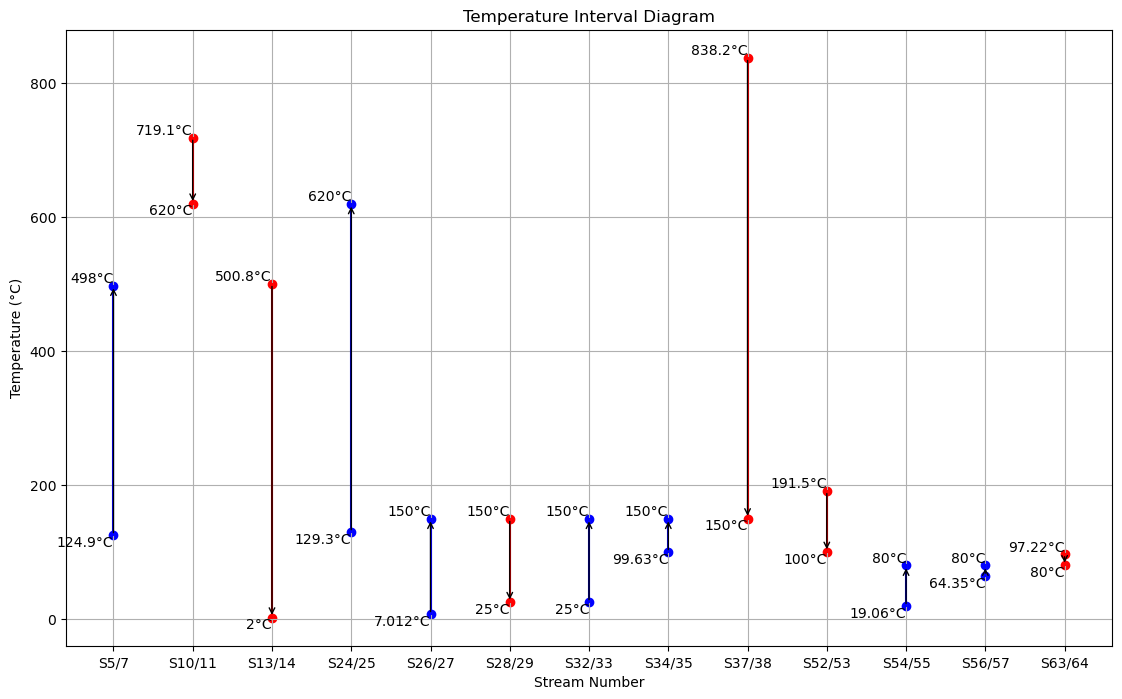

In [7]:
def draw_temperature_interval_diagram(intervals_df):
    """
    Draws a temperature interval diagram for Pinch Analysis with temperature on the y-axis
    and stream numbers on the x-axis. Differentiates between hot and cold streams with
    different colors and arrow directions. Annotates the starting and end temperatures for each stream.

    Parameters:
    intervals_df (DataFrame): DataFrame containing temperature intervals and stream numbers.
    """
    
    # Sort streams numerically based on the number after the 'S'
    def extract_number(s):
        return int(re.search(r'\d+', s).group())

    
    plt.figure(figsize=(13.5, 8))

    # Create a dictionary to store the highest and lowest temperature for each stream
    stream_temp_ranges = {}

    # Update the temperature range for each stream
    for index, row in intervals_df.iterrows():
        for stream in row['streamNumbers_cold']:
            if stream not in stream_temp_ranges:
                stream_temp_ranges[stream] = {'min': row['t2'], 'max': row['t2'], 'type': 'cold'}
            else:
                stream_temp_ranges[stream]['min'] = min(stream_temp_ranges[stream]['min'], row['t2'])
                stream_temp_ranges[stream]['max'] = max(stream_temp_ranges[stream]['max'], row['t2'])

        for stream in row['streamNumbers_hot']:
            if stream not in stream_temp_ranges:
                stream_temp_ranges[stream] = {'min': row['t1'], 'max': row['t1'], 'type': 'hot'}
            else:
                stream_temp_ranges[stream]['min'] = min(stream_temp_ranges[stream]['min'], row['t1'])
                stream_temp_ranges[stream]['max'] = max(stream_temp_ranges[stream]['max'], row['t1'])

    all_streams = sorted(stream_temp_ranges.keys(), key=extract_number)
    stream_positions = {stream: i for i, stream in enumerate(all_streams, start=1)}

    # Plotting the streams
    for stream, temps in stream_temp_ranges.items():
        x_pos = stream_positions[stream]
        color = 'red' if temps['type'] == 'hot' else 'blue'
        plt.plot([x_pos, x_pos], [temps['max'], temps['min']], color=color, label='Hot Stream' if temps['type'] == 'hot' else 'Cold Stream')
        plt.scatter([x_pos, x_pos], [temps['max'], temps['min']], color=color)

        # Annotate the temperatures at the start and end points with four significant figures
        max_temp_formatted = "{:.4g}".format(temps['max'])
        min_temp_formatted = "{:.4g}".format(temps['min'])
        plt.text(x_pos, temps['max'], f'{max_temp_formatted}°C', ha='right', va='bottom')
        plt.text(x_pos, temps['min'], f'{min_temp_formatted}°C', ha='right', va='top')


        # Different arrow styles for hot and cold streams
        if temps['type'] == 'hot':
            plt.annotate('', xy=(x_pos, temps['min']), xytext=(x_pos, temps['max']),
                         arrowprops=dict(facecolor=color, arrowstyle='->'))
        else:
            plt.annotate('', xy=(x_pos, temps['max']), xytext=(x_pos, temps['min']),
                         arrowprops=dict(facecolor=color, arrowstyle='->'))

    plt.ylabel('Temperature (°C)')
    plt.xlabel('Stream Number')
    plt.title('Temperature Interval Diagram')
    #plt.legend()
    plt.grid(True)
    plt.xticks(range(1, len(all_streams) + 1), all_streams)
    
#     # Sort intervals_df by t1 and t2 to ensure they are in the correct sequence
#     intervals_df = intervals_df.sort_values(by=['t1', 't2'])

#     # Draw a lightly shaded line for t1 and t2 of each interval
#     for _, row in intervals_df.iterrows():
#         current_t1 = row['t1']
#         current_t2 = row['t2']
#         plt.axhline(y=current_t1, color='grey', linestyle='-', alpha=0.5)  # Light line for current t1
#         plt.axhline(y=current_t2, color='grey', linestyle='-', alpha=0.5)  # Light line for current t2

    plt.show()

draw_temperature_interval_diagram(Temp_intervals)


# Compute net utility usage per interval

In [8]:
def compute_utilities_for_all_intervals(stream_df, interval_df):
    """Compute the utilities for all intervals in the interval DataFrame."""
    
    def parse_stream_data(stream_df):
        """Parse the stream data (flux) from a DataFrame into a dictionary."""
        stream_dict = {}
        for index, row in stream_df.iterrows():
            stream_number = row['Stream Number']
            flux = row['Flux [kW / K]']
            stream_dict[stream_number] = flux
        return stream_dict
    
    streams = parse_stream_data(stream_df)

    utilities_data = []

    for i in range(len(interval_df) - 1):
        hot_utility = 0
        cold_utility = 0

        current_interval = interval_df.iloc[i]
        next_interval = interval_df.iloc[i + 1]

        # Hot
        t1_diff = current_interval['t1'] - next_interval['t1']
        # Cold
        t2_diff = next_interval['t2'] - current_interval['t2']

        current_hot_streams = current_interval['streamNumbers_hot']
        current_cold_streams = current_interval['streamNumbers_cold']
        
        next_hot_streams = next_interval['streamNumbers_hot']
        next_cold_streams = next_interval['streamNumbers_cold']

        for stream in current_hot_streams:
            if stream in streams and stream in next_hot_streams:
                hot_utility += t1_diff * streams[stream]

        for stream in current_cold_streams:
            if stream in streams and stream in next_cold_streams:
                cold_utility += t2_diff * streams[stream]

        net_utility = hot_utility + cold_utility
        status = 'Surplus' if net_utility > 0 else 'Deficit'
        utilities_data.append({
            'Interval': i, 
            'Hot Utility [kW]': hot_utility, 
            'Cold Utility [kW]': cold_utility, 
            'Net Utility [kW]': net_utility,
            'Status': status
        })

    return pd.DataFrame(utilities_data)


In [9]:
stream_data_df = updated_stream_data  
interval_data_df = Temp_intervals  

utilities_df = compute_utilities_for_all_intervals(stream_data_df, interval_data_df)
utilities_df

,Interval,Hot Utility [kW],Cold Utility [kW],Net Utility [kW],Status
0,0,495.643633,0.000000,495.643633,Surplus
1,1,560.576506,0.000000,560.576506,Surplus
2,2,62.941084,-0.932741,62.008342,Surplus
3,3,465.960846,-10.446703,455.514143,Surplus
4,4,30.148008,-136.824675,-106.676667,Deficit
5,5,6800.862676,-5838.972831,961.889845,Surplus
6,6,1104.958647,-594.975304,509.983343,Surplus
7,7,350.658437,-341.468949,9.189487,Surplus
8,8,469.879047,-364.797139,105.081908,Surplus
9,9,193.442382,-149.771456,43.670925,Surplus


# Find the Minimum Cooling requirement and the pinch if applicable

<img src="./images/Minimum_Cooling_requirement.png" alt="Find the Minimum Cooling requirement">

In [10]:
# Minimum cooling requirements

x = 0;
net_utility = 0;
counter = 0;

for i in range(len(utilities_df)-1):
    
    if utilities_df['Status'][i] == 'Deficit': 
    
        if utilities_df['Status'][i+1] == 'Surplus':
            if (net_utility < 0):
                x = i+1
                break
        net_utility = utilities_df['Net Utility [kW]'][i] + utilities_df['Net Utility [kW]'][i+1]
                
    if utilities_df['Status'][i] == 'Surplus':
        if utilities_df['Status'][i+1] == 'Deficit':
            net_utility = utilities_df['Net Utility [kW]'][i] + utilities_df['Net Utility [kW]'][i+1]
        else: 
            if (net_utility < 0):
                x = i
                break
    counter += 1
#     print(counter)

if counter == len(utilities_df):
    df6 = utilities_df[utilities_df['Interval'] > 0].copy()
else: 
    df6 = utilities_df[utilities_df['Interval'] > x-1].copy()

df6['Cumulative Utility [kW]'] = df6['Net Utility [kW]'].cumsum()

minimum_cooling_requirement = df6['Cumulative Utility [kW]'][len(utilities_df) - 1]


print(utilities_df) 
print("\n")
print(df6)
print("\n")
print(f"Minimum cooling requirement: {minimum_cooling_requirement} [kW]")

    Interval  Hot Utility [kW]  Cold Utility [kW]  Net Utility [kW]   Status
0          0        495.643633           0.000000        495.643633  Surplus
1          1        560.576506           0.000000        560.576506  Surplus
2          2         62.941084          -0.932741         62.008342  Surplus
3          3        465.960846         -10.446703        455.514143  Surplus
4          4         30.148008        -136.824675       -106.676667  Deficit
5          5       6800.862676       -5838.972831        961.889845  Surplus
6          6       1104.958647        -594.975304        509.983343  Surplus
7          7        350.658437        -341.468949          9.189487  Surplus
8          8        469.879047        -364.797139        105.081908  Surplus
9          9        193.442382        -149.771456         43.670925  Surplus
10        10       1112.061972        -385.967092        726.094881  Surplus
11        11        423.771791         -68.565135        355.206656  Surplus

# Procedure for Hot Curve


<img src="./images/Hot.png" alt="Procedure for hot curve">

In [11]:
def prepare_hot_enthalpy_data(dfx, tmp_hot):
    """
    Prepare enthalpy data for hot utility from a DataFrame.
    
    Args:
    df: DataFrame containing hot utility values and temperatures.

    Returns:
    DataFrame with cumulative hot utility values and temperatures.
    """
    # Reverse the order of hot utility and calculate cumulative utility
    reversed_hot_utility = list(reversed(dfx['Hot Utility [kW]'].tolist()))
    reversed_hot_utility.insert(0, 0)  # Add 0 utility at the start
    df_hot = pd.DataFrame({"Cumulative Utility [kW]": reversed_hot_utility, "Temperature": tmp_hot})
    df_hot['Cumulative Utility [kW]'] = df_hot['Cumulative Utility [kW]'].cumsum()
    return df_hot

In [12]:
temperatures_hot = Temp_intervals.copy()['t1'][::-1].reset_index(drop=True)
# print(temperatures_hot)

df_hot = prepare_hot_enthalpy_data(utilities_df, temperatures_hot)
print(df_hot)

    Cumulative Utility [kW]  Temperature
0                  0.000000     2.000000
1                267.682410    17.011657
2                410.127649    25.000000
3                535.764809    29.064709
4                719.220088    34.999994
5               1935.598031    74.353181
6               2110.137045    80.000000
7               2467.810653    90.000000
8               2726.032474    97.219482
9               2811.976229   100.000000
10              3235.748020   109.634877
11              4347.809992   134.918722
12              4541.252374   139.316828
13              5011.131421   150.000000
14              5361.789858   160.000000
15              6466.748505   191.510967
16             13267.611181   500.753518
17             13297.759188   508.000000
18             13763.720034   620.000000
19             13826.661118   630.000000
20             14387.237623   719.063689
21             14882.881256   838.198348


# Procedure for Cold Curve


<img src="./images/Cold.png" alt="Procedure for cold curve">

In [13]:
def prepare_cold_enthalpy_data(dfx, min_cooling_requirement, tmp_cold):
    """
    Prepare enthalpy data for cold utility from a DataFrame.
    
    Args:
    df: DataFrame containing cold utility values and temperatures.
    min_cooling_requirement: Minimum cooling requirement for the 0th interval.

    Returns:
    DataFrame with cumulative cold utility values and temperatures.
    """
    # Reverse the order of cold utility, add minimum cooling requirement at the start
    reversed_cold_utility = list(reversed(dfx['Cold Utility [kW]'].tolist()))
    reversed_cold_utility.insert(0, min_cooling_requirement)
    df_cold = pd.DataFrame({"Cumulative Utility [kW]": reversed_cold_utility, "Temperature": tmp_cold})
    df_cold['Cumulative Utility [kW]'] = df_cold['Cumulative Utility [kW]'].cumsum()
    for i in range(len(df_cold['Cumulative Utility [kW]'])): 
        if df_cold['Cumulative Utility [kW]'][i] < 0: 
            df_cold['Cumulative Utility [kW]'][i] = - df_cold['Cumulative Utility [kW]'][i]
            
            
    return df_cold

In [14]:
temperatures_cold = [i - 10 for i in temperatures_hot]
# print(temperatures_cold)

# Assuming hot_utility_results, cold_utility_results, temperatures_hot, and temperatures_cold are defined
min_cooling_requirement = minimum_cooling_requirement

df_cold = prepare_cold_enthalpy_data(utilities_df, min_cooling_requirement, temperatures_cold)
print(df_cold)


    Cumulative Utility [kW]  Temperature
0               6060.288841    -8.000000
1               6060.288841     7.011657
2               6004.032724    15.000000
3               5975.407921    19.064709
4               5909.824150    24.999994
5               5472.063958    64.353181
6               5374.449031    70.000000
7               5201.581932    80.000000
8               5150.205586    87.219482
9               5130.418453    90.000000
10              5061.853318    99.634877
11              4675.886226   124.918722
12              4526.114770   129.316828
13              4161.317631   140.000000
14              3819.848681   150.000000
15              3224.873377   181.510967
16              2614.099454   490.753518
17              2750.924129   498.000000
18              2761.370832   610.000000
19              2762.303573   620.000000
20              2762.303573   709.063689
21              2762.303573   828.198348


# Plot the Temperature-Enthalpy Diagram



<img src="./images/Temperature_Enthalpy.png" alt="Temperature_Enthalpy">

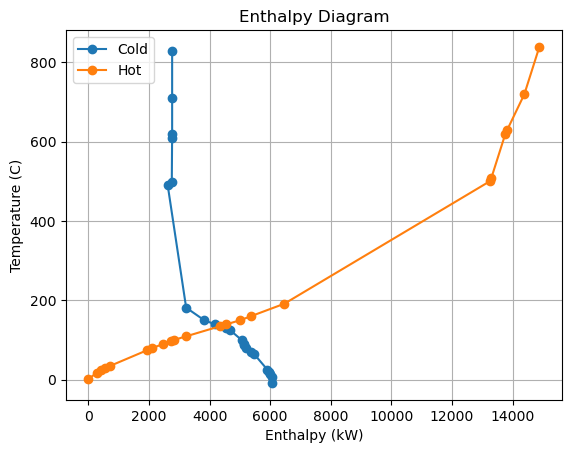

In [15]:
def plot_enthalpy_diagrams(df_hot, df_cold):
    """
    Plot enthalpy diagrams for hot and cold streams.
    
    Args:
    df_hot: DataFrame containing hot utility data.
    df_cold: DataFrame containing cold utility data.
    """
    plt.plot(df_cold["Cumulative Utility [kW]"], df_cold["Temperature"], "-o", label='Cold')
    plt.plot(df_hot["Cumulative Utility [kW]"], df_hot["Temperature"], "-o", label='Hot')
    plt.xlabel('Enthalpy (kW)')
    plt.ylabel('Temperature (C)')
    plt.title('Enthalpy Diagram')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_enthalpy_diagrams(df_hot, df_cold)

In [16]:
def get_interpolated_temps(df_hot, df_cold):
    interp_hot = interp1d(df_hot['Cumulative Utility [kW]'], df_hot['Temperature'], kind='linear')
    interp_cold = interp1d(df_cold['Cumulative Utility [kW]'], df_cold['Temperature'], kind='linear')
    return interp_hot, interp_cold

def calculate_temperature_diff(interp_hot, interp_cold, cumulative_utility_values):
    return np.abs(interp_cold(cumulative_utility_values) - interp_hot(cumulative_utility_values))

def find_min_temp_diff(temperature_diff, cumulative_utility_values):
    min_temp_diff_index = np.argmin(temperature_diff)
    return temperature_diff[min_temp_diff_index], cumulative_utility_values[min_temp_diff_index]

def plot_temp_diff(cumulative_utility_values, temperature_diff, min_temp_diff, min_temp_diff_utility, min_temp_hot_side, min_temp_cold_side):
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_utility_values, temperature_diff, label='Temperature Difference')

    plt.annotate(f'Min Temp Diff: {min_temp_diff:.2f}°C\nHot Side: {min_temp_hot_side:.2f}°C\nCold Side: {min_temp_cold_side:.2f}°C',
                 xy=(min_temp_diff_utility, min_temp_diff),
                 xytext=(min_temp_diff_utility + 0.1 * (cumulative_utility_values[-1] - cumulative_utility_values[0]), 
                         min_temp_diff + 0.05 * (temperature_diff.max() - temperature_diff.min())),
                 arrowprops=dict(facecolor='red', shrink=0.05),
                 horizontalalignment='right')

    plt.xlabel('Enthalpy [kW]')
    plt.ylabel('Absolute Temperature Difference (°C)')
    plt.title('Absolute Temperature Difference over Enthalpy')
    plt.legend()
    plt.grid(True)
    plt.show()

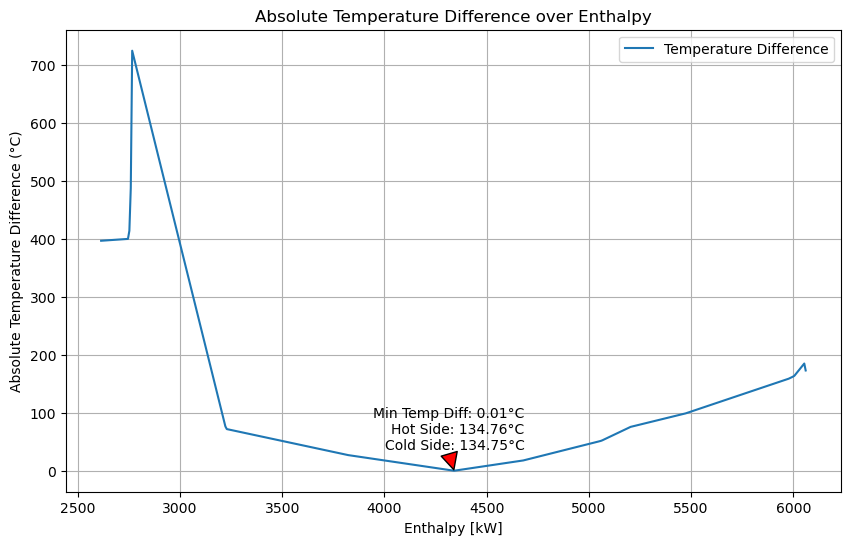

In [17]:
interp_hot, interp_cold = get_interpolated_temps(df_hot, df_cold)

cumulative_utility_min = max(df_hot['Cumulative Utility [kW]'].min(), df_cold['Cumulative Utility [kW]'].min())
cumulative_utility_max = min(df_hot['Cumulative Utility [kW]'].max(), df_cold['Cumulative Utility [kW]'].max())
cumulative_utility_values = np.linspace(cumulative_utility_min, cumulative_utility_max, 500)

temperature_diff = calculate_temperature_diff(interp_hot, interp_cold, cumulative_utility_values)
min_temp_diff, min_temp_diff_utility = find_min_temp_diff(temperature_diff, cumulative_utility_values)
min_temp_hot_side = interp_hot(min_temp_diff_utility)
min_temp_cold_side = interp_cold(min_temp_diff_utility)

plot_temp_diff(cumulative_utility_values, temperature_diff, min_temp_diff, min_temp_diff_utility, min_temp_hot_side, min_temp_cold_side)


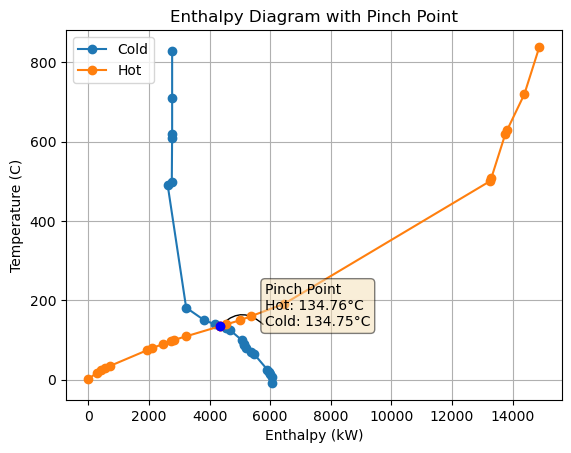

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_enthalpy_diagrams_with_pinch_box(df_hot, df_cold, min_temp_diff_utility, min_temp_hot_side, min_temp_cold_side):
    """
    Plot enthalpy diagrams for hot and cold streams with a text box for the pinch point.
    
    Args:
    df_hot: DataFrame containing hot utility data.
    df_cold: DataFrame containing cold utility data.
    min_temp_diff_utility: The enthalpy at the pinch point.
    min_temp_hot_side: The temperature on the hot side at the pinch point.
    min_temp_cold_side: The temperature on the cold side at the pinch point.
    """
    plt.plot(df_cold["Cumulative Utility [kW]"], df_cold["Temperature"], "-o", label='Cold')
    plt.plot(df_hot["Cumulative Utility [kW]"], df_hot["Temperature"], "-o", label='Hot')

    # Plotting the pinch point
    plt.scatter(min_temp_diff_utility, min_temp_hot_side, color='red', zorder=5)
    plt.scatter(min_temp_diff_utility, min_temp_cold_side, color='blue', zorder=5)

    # Creating a text box for pinch point information
    textstr = f'Pinch Point\nHot: {min_temp_hot_side:.2f}°C\nCold: {min_temp_cold_side:.2f}°C'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textbox = plt.text(min_temp_diff_utility + 0.1 * (df_hot["Cumulative Utility [kW]"].max() - df_hot["Cumulative Utility [kW]"].min()), 
                       (min_temp_hot_side + min_temp_cold_side) / 2,
                       textstr, bbox=props)

    # Drawing an arrow pointing to the pinch point
    plt.gca().add_patch(mpatches.FancyArrowPatch((textbox.get_position()[0], textbox.get_position()[1]), 
                                                 (min_temp_diff_utility, min_temp_hot_side),
                                                 connectionstyle="arc3,rad=.5", arrowstyle='->', color='black'))

    plt.xlabel('Enthalpy (kW)')
    plt.ylabel('Temperature (C)')
    plt.title('Enthalpy Diagram with Pinch Point')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting the diagram with the pinch point box
plot_enthalpy_diagrams_with_pinch_box(df_hot, df_cold, min_temp_diff_utility, min_temp_hot_side, min_temp_cold_side)
